## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [1]:
import glob

import numpy as np
import scipy as sp
import scipy.io
import matplotlib.pyplot as plt
import scipy.signal


def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def RunPulseRateAlgorithm(data_fl, ref_fl):
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    # Load the BMP reference data
    bpm_ref = np.array(sp.io.loadmat(ref_fl)['BPM0'])
    
    # Compute pulse rate estimates and estimation confidence.
    # Extracting the dominant frequencies of signals
    f_ppg, cf = freq_analyzer(ppg)
    f_ax, _ = freq_analyzer(accx)
    f_ay, _ = freq_analyzer(accy)
    f_az, _ = freq_analyzer(accz)
    # As demostrated in readme file, if the first strongest frequency of PPG is 
    # same as the acc strongest freq, the secon strongest freq is picked
    bpm=[]
    conf=[]
    for i in range(f_ppg.shape[0]):
#         bpm.append(f_ppg[i,0])
#         conf.append(cf[i,0])
        k=0
        for j, f in enumerate(f_ppg[i,:]):
            if f in (f_ax[i,k], f_ay[i,k], f_az[i,k]):
                k+=1
                pass
            else:
                bpm.append(f)
                conf.append(cf[i,j])
                break
            if k==3:
                bpm.append(f_ppg[i,0])
                conf.append(cf[i,0])

    errors = np.abs(bpm_ref.squeeze() - np.array(bpm))
    confidence = conf
    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
#     errors, confconfidence = confidence = np.ones(100), np.ones(100)  # Dummy placeholders. Remove
    return errors, confidence


##
# Helper functions
fs=125
# freq_analyzer use the specgram functions to explore the fft of the signal in window of 8s
# and overlap of 6s. The strongest freqs are then seleccted using sp.signal.find_peaks method
# which are later sorted accorging to their corresponding magneitude. Finally three top strong freqs
# are extracted.
def freq_analyzer(signal, fs=fs):
    dominant_fr=[]
    confidence=[]
    spec, fr, t, _ = plt.specgram(bpf(signal, fs), NFFT=fs*8 , Fs=fs, noverlap=6*fs)
    spec_energy = np.sum(spec**2, axis=0)

    for i in range(spec.shape[1]):
        # finding the signal peaks
        index = sp.signal.find_peaks(spec[:40,i])[0]
        # sorting freqs based in their magnitude
        idx2 = sorted(index, key=lambda x: spec[x,i], reverse=True)
        # changing Hz to bpm
        selected_fr = fr[idx2]*60
        # selecting only 3 tops
        dominant_fr.append(selected_fr[:3])
        
        # uisng signal energy critiria to calculate the confidence
        # The proportion of selected freq energy within 1Hz to the total signal energy
        spec_energy = spec[:,i]**2
        energy_ratio=[]
        for j in idx2[:3]:
            # get signals 0.5 Hz lower and higher than the selected peak freq:
            lower_bound = j-4 if j>7 else 0
            upper_bound = j+5
            energy_ratio.append(np.sum(spec_energy[lower_bound:upper_bound])/np.sum(spec_energy))
        confidence.append(energy_ratio)
        
    return np.array(dominant_fr), np.array(confidence)

# Bandpass filter function to filter signal freq between 40 bpm and 240 bpm
def bpf(signal, fs):
    b, a = sp.signal.butter(3, (40/60, 240/60), btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)


14.35310569688713

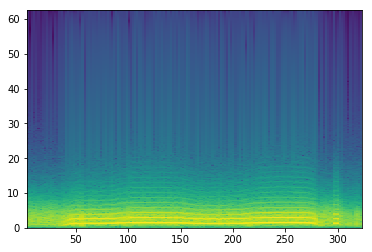

In [2]:
Evaluate()

-----
### Project Write-up

Answer the following prompts to demonstrate understanding of the algorithm you wrote for this specific context.

> - **Code Description** - Include details so someone unfamiliar with your project will know how to run your code and use your algorithm. 
> - **Data Description** - Describe the dataset that was used to train and test the algorithm. Include its short-comings and what data would be required to build a more complete dataset.
> - **Algorithhm Description** will include the following:
>   - how the algorithm works
>   - the specific aspects of the physiology that it takes advantage of
>   - a describtion of the algorithm outputs
>   - caveats on algorithm outputs 
>   - common failure modes
> - **Algorithm Performance** - Detail how performance was computed (eg. using cross-validation or train-test split) and what metrics were optimized for. Include error metrics that would be relevant to users of your algorithm. Caveat your performance numbers by acknowledging how generalizable they may or may not be on different datasets.

Your write-up goes here...

---
**Code Description**: please refer to the code cell above to check for the comments

**Algorithhm Description & Algorithm Performance**: 

freq_analyzer function uses the specgram functions to explore the fft of the signal in window of 8s and overlap of 6s. The strongest freqs are then seleccted using sp.signal.find_peaks method which are later sorted according to their corresponding magnitude. Finally three top strong freqs are extracted.

To compute the confidence, the energy of the signal at the  selected frequencies along with the frequencies that are 0.5 Hz lower and higher. The calculated energy is then divided by the total signal energy.

Algorithm performance is evaluated according to two functions of Evaluate and AggregateErrorMetric which is based on the mean absolute error on the best 90% estimates. This is more elaborated below.

- *Finding the heart beat rate:*
    
    1st approach: the first dominant freq of the ppg signal was picked. This resulted best MAE of about 20 
    
    2nd approach: if the first dominant freq of the ppg signal was the same as the first acc signal, then the second strongest freq of ppg is picked as the heart beat rate. Otherwise, the first strongest freq of ppg is chosen. The best MAE error decreased to about 15.1. The unit test gave an error of around 8.
    
    3rd approach: each of the 3 top freqs of the ppg signal is compared with each of the 3 top freq of the acc signals in order. If the ppg freq is among the acc freq, next ppg freq is studied, otherwise the ppg freq is reported as the heart beat rate. If the each of the 3 top freqs of the ppg signal is among the 3 top freqs of acc signal, the first strongest freqs of the ppg signal is selected. The best MAE decreased to 14.3 and the unit test gave an error of around 5.

This project was not an ML project so no learning/trainable algorithm was used.

#### Data Description 

Each dataset has 6 rows. The first row is a simultaneous recording of ECG, second row and the third row are two channels of PPG, which are recorded from the wrist of each subject. The last three rows are simultaneous recordings of acceleration data (x,y,z). The proposed algorithm performs with the second channel of PPG and 3 accelerometers’ reading. 

considering ECG channel would help to improve the result.

As an example, the first file is analyzed.  Following  shows the four signals along with their FFT taken through whole signal. 


In [3]:
data_fls, ref_fls = LoadTroikaDataset()
bpm_ref = sp.io.loadmat(ref_fls[0])['BPM0']

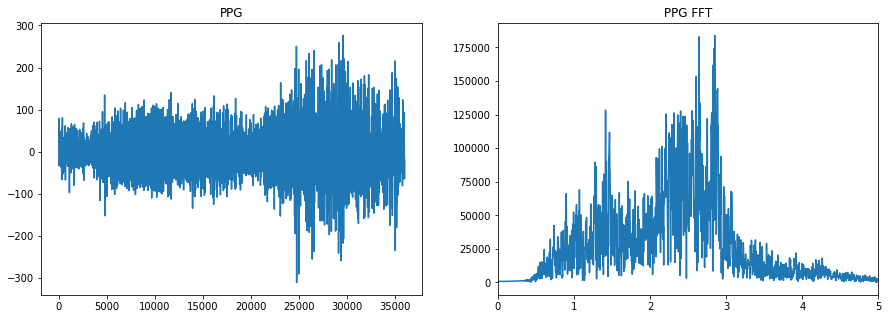

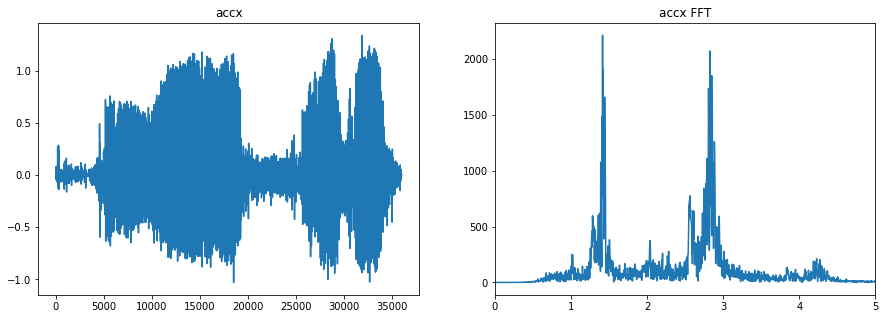

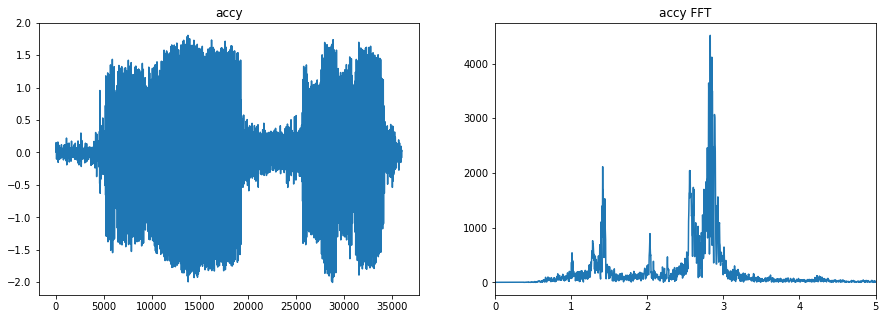

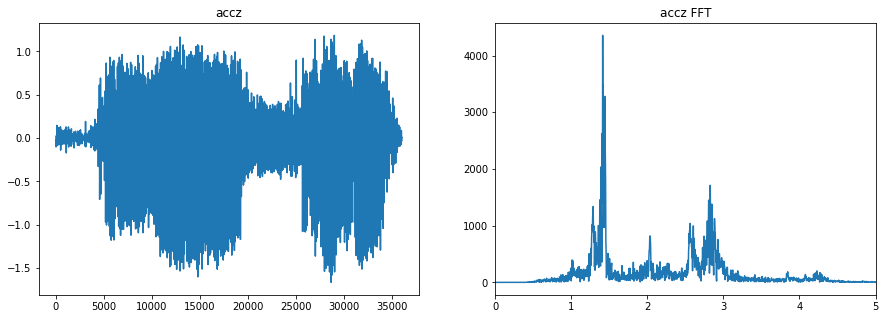

In [4]:
fs=125
ppg, accx, accy, accz = sp.io.loadmat(data_fls[2])['sig'][2:]

def plotter(signal, fs=fs, title=None):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(signal)
    plt.title(title)

    freq = np.fft.rfftfreq(len(signal), d=1/fs)
    mag = np.fft.rfft(signal)
    plt.subplot(1,2,2)
    plt.xlim(0,5)
    plt.plot(freq, np.abs(mag))
    plt.title(f'{title} FFT')
    
plotter(bpf(ppg, fs), title='PPG')
plotter(bpf(accx, fs), title='accx')
plotter(bpf(accy, fs), title='accy')
plotter(bpf(accz, fs), title='accz')

specgram of all signals are computed below. PPG specgram is plotted which affirms the heart beat occurred in less than 6 Hz and shows gradual increase. This increase reflects the activity performed by the subjects that resulted in higher heart beat rate.

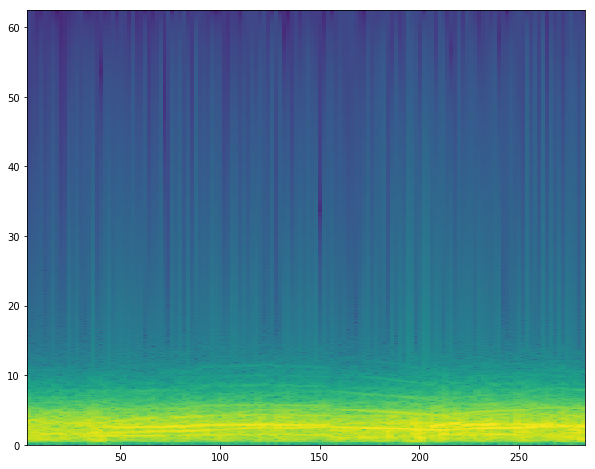

In [29]:
plt.figure(figsize=(10,8))
spec_acx, fr_acx, t_acx, _ = plt.specgram(bpf(accx, fs), NFFT=fs*8 , Fs=fs, noverlap=6*fs)
spec_acy, fr_acy, t_acy, _ = plt.specgram(bpf(accy, fs), NFFT=fs*8 , Fs=fs, noverlap=6*fs)
spec_acz, fr_acz, t_acz, _ = plt.specgram(bpf(accz, fs), NFFT=fs*8 , Fs=fs, noverlap=6*fs)
spec, fr, t_ppg, _ = plt.specgram(bpf(ppg, fs), NFFT=fs*8 , Fs=fs, noverlap=6*fs)


This function plot signals in 8s window in addition to show the peaks and values of the 3 top frequencies. 3 different time spots are chosen to show the signal changes.

In [34]:
import pandas as pd

fdom_ppg, _ = freq_analyzer(ppg)
fdom_acx, _ = freq_analyzer(accx)
fdom_acy, _ = freq_analyzer(accy)
fdom_acz, _ = freq_analyzer(accz)
plt.close()

def time_slot_plotter(t = 0):
    print(f"Dominant Frequencies (BPM) at t = {t_ppg[t]}s:")

    df = pd.DataFrame(np.array([fdom_ppg[t,:], fdom_acx[t,:], fdom_acy[t,:], 
                               fdom_acz[t,:]]), columns = ['1st dom. freq.', '2nd dom. freq.', '3rd dom. freq.'],
                     index =['PPG','accx', 'accy', 'accz' ])
    
    plt.figure(figsize=(16,5))
    
    plt.subplot(1,4,1)
    plt.plot(spec[:40,t])
    idx = sp.signal.find_peaks(spec[:40,t])[0]
    plt.plot(idx, spec[idx,t], 'ro')
    plt.title('PPG')
    plt.ylabel(f't = {t_ppg[t]}s', {'fontsize': 20})

    plt.subplot(1,4,2)
    plt.plot(spec_acx[:40,t])
    idx_acx = sp.signal.find_peaks(spec_acx[:40,t])[0]
    plt.plot(idx_acx, spec_acx[idx_acx,t], 'ro')
    plt.title('accx')

    plt.subplot(1,4,3)
    plt.plot(spec_acy[:40,t])
    idx_acy = sp.signal.find_peaks(spec_acy[:40,t])[0]
    plt.plot(idx_acy, spec_acy[idx_acy,t], 'ro')
    plt.title('accy')

    plt.subplot(1,4,4)
    plt.plot(spec_acz[:40,t])
    idx_acz = sp.signal.find_peaks(spec_acz[:40,t])[0]
    plt.plot(idx_acz, spec_acz[idx_acz,t], 'ro')
    plt.title('accz')
    
    plt.subplots_adjust(wspace = 0.3)
    
    return df

Dominant Frequencies (BPM) at t = 4.0s:


,1st dom. freq.,2nd dom. freq.,3rd dom. freq.
PPG,135.0,75.0,52.5
accx,150.0,97.5,60.0
accy,60.0,112.5,97.5
accz,172.5,120.0,90.0


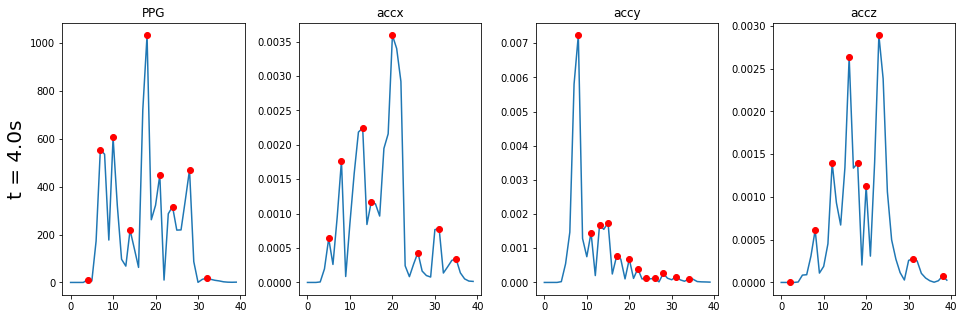

In [35]:
time_slot_plotter(0)

Dominant Frequencies (BPM) at t = 64.0s:


,1st dom. freq.,2nd dom. freq.,3rd dom. freq.
PPG,157.5,112.5,75.0
accx,157.5,75.0,232.5
accy,157.5,75.0,180.0
accz,75.0,157.5,232.5


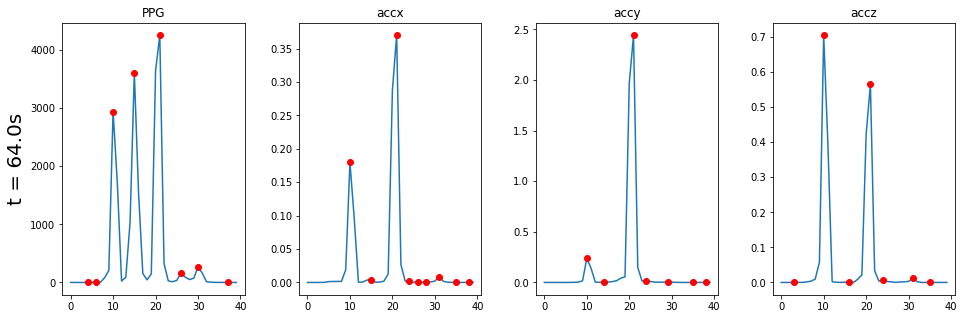

In [36]:
time_slot_plotter(30)

Dominant Frequencies (BPM) at t = 264.0s:


,1st dom. freq.,2nd dom. freq.,3rd dom. freq.
PPG,157.5,180.0,75.0
accx,172.5,90.0,157.5
accy,172.5,90.0,135.0
accz,90.0,172.5,112.5


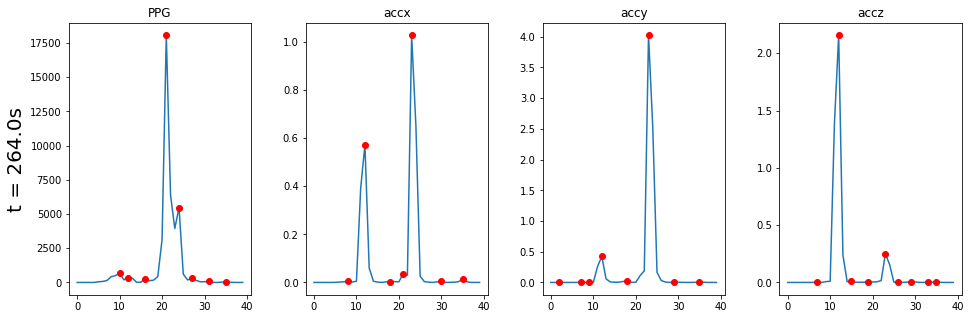

In [37]:
time_slot_plotter(130)

-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 